In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
import geopandas as gpd
from sklearn import covariance
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import matplotlib.colors as mcolors
from scipy.stats import spearmanr
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Function to plot nodes in the geographical position
def same_position_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))  
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [5]:
def plot_network(matrix, threshold, same_position_data_func, df_info):
    # Prepare the matrix for network illustration
    links = matrix.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links2 = matrix.stack().reset_index()
    links2.columns = ['var1', 'var2', 'value']

    links = links.loc[(abs(links['value']) >= threshold) & (links['var1'] != links['var2'])]
    links2 = links2.loc[(links2['var1'] != links2['var2'])]

    # Create graph
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', edge_attr='value', create_using=nx.Graph())

    all_nodes = pd.Series(pd.concat([links2['var1'], links2['var2']])).unique()

    # Create a complete graph with all nodes
    G_complete = nx.complete_graph(all_nodes)

    # Nodes position and colors
    coordinates = same_position_data_func(df_info)
    coordinates = coordinates[G_complete.nodes]
    colores = df_info.Habitat.values[G_complete.nodes]
    positions = dict(zip(G_complete.nodes, coordinates))

    # Edge weights
    edge_weights = [abs(G[u][v]['value']) for u, v in G.edges()]

    plt.figure(figsize=(15, 10))

    node_size = 1400
    node_color = colores
    node_border_color = 'white'
    node_border_width = 0
    node_labels = {node: node for node in G_complete.nodes()}
    nx.draw_networkx_nodes(G_complete, positions, nodelist=G_complete.nodes(), node_size=node_size, node_color=node_color,
                           linewidths=node_border_width, edgecolors=node_border_color, cmap="summer_r")
    nx.draw_networkx_labels(G_complete, positions, labels=node_labels, font_color='black')

    min_width = 1
    max_width = 5
    scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights]

    # Plot final graph
    nx.draw_networkx_edges(G, positions, width=scaled_widths, edge_color="darkblue", alpha=0.8)

    plt.show()
    return G, G_complete

Load acoustic structures data 

In [7]:
df1 = pd.read_excel(r'/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Matrices_out/Matriz_Resumen_sonotipos_completos.xlsx')
df2 = df1.iloc[:,1:]
df2

,2,3,4,5,6,7,8,9,10,11,...,346,348,349,351,352,353,354,355,356,358
0,2147,5991,965,2070,13,11267,2588,13203,370,372,...,178,68,38,25,51,33,2,1,1,17
1,1733,4502,637,2110,50,2307,1232,5179,91,65,...,140,99,37,54,129,43,0,0,1,21
2,640,5983,704,6192,0,13213,151,6781,900,54,...,143,191,20,46,16,34,1,1,0,21
3,450,6319,359,4335,0,10314,516,9410,627,289,...,181,147,42,39,80,33,1,1,3,32
4,391,9177,468,1416,0,2120,846,1809,213,1538,...,214,284,38,112,49,135,1,1,2,64
5,751,7728,330,675,2,12486,401,5930,1261,2072,...,80,245,32,153,64,48,5,4,2,41
6,776,12360,1500,1604,5,15887,692,8396,1237,2925,...,168,121,19,96,123,38,11,0,2,37
7,535,8602,490,543,1,5782,634,4752,760,1133,...,192,102,30,95,114,87,8,0,1,29
8,698,4911,252,2953,14,9522,647,6002,234,1487,...,307,176,26,66,77,87,0,1,0,24
9,52,4394,88,6,0,2430,8,513,68,0,...,212,93,4,50,80,23,0,0,3,18


In [9]:
df_info = pd.read_excel(r'/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Matrices_input/Matrix_information.xlsx')
df_info

,Point,latitude,longitude,Habitat,Site,Recording Name
0,KLSA01,7.36574,-73.85669,1,0,SMA03286
1,KLSA02,7.36832,-73.86041,1,1,SMA03294
2,KLSA03,7.36765,-73.85181,2,2,SMA03332
3,KLSA04,7.36233,-73.85412,1,3,SMA03322
4,KLSA05,7.36389,-73.86101,3,4,SMA03210
5,KLSA06,7.36238,-73.84993,1,5,SMA03328
6,KLSA07,7.35796,-73.85642,3,6,SMA03297
7,KLSA08,7.36733,-73.86392,1,7,SMA03175ICP
8,KLSA09,7.35986,-73.86059,1,8,SMA03247
9,KLSA10,7.36400,-73.87019,2,9,SMA03327


In [11]:
df_norm = (df2 - df2.min()) / (df2.max() - df2.min())
df_norm

,2,3,4,5,6,7,8,9,10,11,...,346,348,349,351,352,353,354,355,356,358
0,1.000000,0.167103,0.396474,0.333657,0.26,0.664415,0.865481,1.000000,0.278543,0.127179,...,0.115976,0.009174,0.539683,0.000000,0.141844,0.198529,0.181818,0.25,0.333333,0.088889
1,0.804440,0.011301,0.248192,0.340123,1.00,0.013583,0.410600,0.367691,0.052632,0.022222,...,0.071006,0.151376,0.523810,0.226562,0.418440,0.272059,0.000000,0.00,0.333333,0.133333
2,0.288144,0.166266,0.278481,1.000000,0.00,0.805767,0.047970,0.493932,0.707692,0.018462,...,0.074556,0.573394,0.253968,0.164062,0.017730,0.205882,0.090909,0.25,0.000000,0.133333
3,0.198394,0.201423,0.122514,0.699806,0.00,0.595191,0.170413,0.701103,0.486640,0.098803,...,0.119527,0.371560,0.603175,0.109375,0.244681,0.198529,0.090909,0.25,1.000000,0.255556
4,0.170524,0.500471,0.171790,0.227934,0.00,0.000000,0.281114,0.102128,0.151417,0.525812,...,0.158580,1.000000,0.539683,0.679688,0.134752,0.948529,0.090909,0.25,0.666667,0.611111
5,0.340576,0.348854,0.109403,0.108147,0.04,0.752960,0.131835,0.426872,1.000000,0.708376,...,0.000000,0.821101,0.444444,1.000000,0.187943,0.308824,0.454545,1.00,0.666667,0.355556
6,0.352385,0.833525,0.638336,0.258325,0.10,1.000000,0.229453,0.621198,0.980567,1.000000,...,0.104142,0.252294,0.238095,0.554688,0.397163,0.235294,1.000000,0.00,0.666667,0.311111
7,0.238545,0.440306,0.181736,0.086809,0.02,0.265998,0.209997,0.334043,0.594332,0.387350,...,0.132544,0.165138,0.412698,0.546875,0.365248,0.595588,0.727273,0.00,0.333333,0.222222
8,0.315541,0.054096,0.074141,0.476398,0.28,0.537663,0.214358,0.432545,0.168421,0.508376,...,0.268639,0.504587,0.349206,0.320312,0.234043,0.595588,0.000000,0.25,0.000000,0.166667
9,0.010392,0.000000,0.000000,0.000000,0.00,0.022518,0.000000,0.000000,0.034008,0.000000,...,0.156213,0.123853,0.000000,0.195312,0.244681,0.125000,0.000000,0.00,1.000000,0.100000


# Graphical Lasso

In [13]:
datos=np.array(df_norm)
datos2=np.transpose(datos)
datos2 /= datos2.std(axis=0)

In [15]:
edge_model = covariance.GraphicalLassoCV(cv=5, max_iter=1000,verbose=True, assume_centered=True)
edge_model.fit(datos2)

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s
[GraphicalLassoCV] Done refinement  3 out of 4:   0s
[GraphicalLassoCV] Done refinement  4 out of 4:   0s


GraphicalLassoCV(assume_centered=True, cv=5, max_iter=1000, verbose=True)

In [17]:
p = np.around(edge_model.precision_, decimals=3) #matriz de precisión
p=pd.DataFrame(p)
p

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.006,-0.725,-0.025,-0.282,-0.000,0.013,-0.061,0.000,0.000,0.000,-0.623,0.056,-0.106,0.004,0.052,-0.124,-0.000
1,-0.725,1.832,0.000,-0.029,0.000,-0.068,0.026,-0.000,-0.195,0.092,-0.314,0.000,-0.000,0.000,-0.292,-0.111,-0.113
2,-0.025,0.000,1.802,-0.616,-0.037,-0.221,-0.062,0.082,-0.653,-0.000,-0.126,-0.036,-0.047,0.023,0.103,-0.018,0.274
3,-0.282,-0.029,-0.616,2.239,-0.071,-0.018,-0.075,0.067,-0.078,-0.014,-0.497,-0.026,0.075,-0.138,-0.120,-0.581,0.000
4,-0.000,0.000,-0.037,-0.071,1.012,-0.092,0.043,-0.104,-0.149,-0.099,-0.064,-0.086,-0.276,0.000,0.000,-0.144,-0.076
5,0.013,-0.068,-0.221,-0.018,-0.092,1.407,-0.046,-0.403,0.208,0.089,-0.000,-0.006,-0.035,-0.261,0.026,-0.375,-0.020
6,-0.061,0.026,-0.062,-0.075,0.043,-0.046,0.837,-0.131,0.006,0.000,-0.079,-0.106,-0.000,-0.000,-0.141,-0.106,-0.116
7,0.000,-0.000,0.082,0.067,-0.104,-0.403,-0.131,1.434,0.000,0.048,-0.192,-0.441,-0.237,-0.004,-0.085,-0.022,-0.000
8,0.000,-0.195,-0.653,-0.078,-0.149,0.208,0.006,0.000,1.647,-0.213,-0.004,-0.166,0.000,-0.132,-0.000,-0.414,0.000
9,0.000,0.092,-0.000,-0.014,-0.099,0.089,0.000,0.048,-0.213,1.109,0.057,-0.196,-0.092,-0.051,0.088,0.000,-0.077


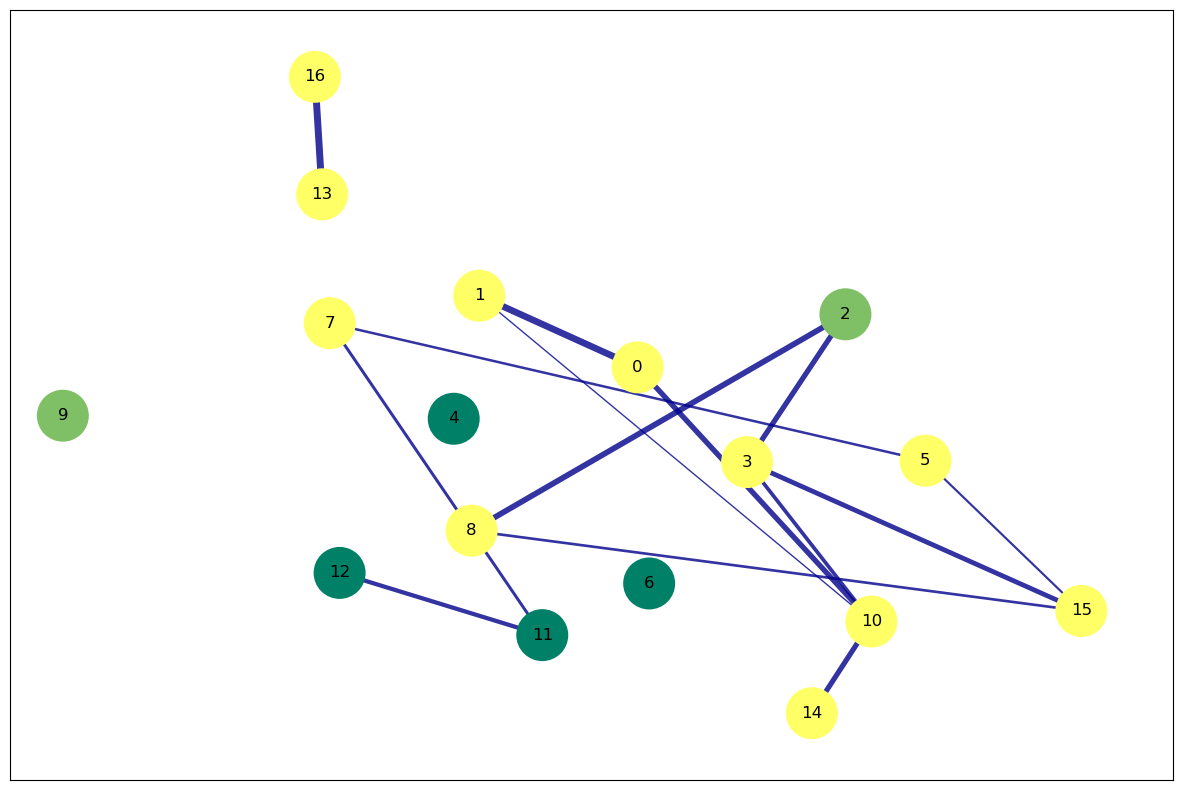

In [19]:
G_Glasso, G_Glasso_complete=plot_network(p, 0.3, same_position_data, df_info)

In [21]:
# Graphical Lasso adjacency matrix generation
adj_matrix_Glasso_sonotipos = np.zeros((len(G_Glasso_complete), len(G_Glasso_complete)))

enlaces = G_Glasso.edges

# Llenar la matriz de adyacencia en las posiciones correspondientes a los enlaces
for enlace in enlaces:
    fila, columna = enlace
    adj_matrix_Glasso_sonotipos[fila, columna] = 1
    adj_matrix_Glasso_sonotipos[columna, fila] = 1

adj_matrix_Glasso_sonotipos_=pd.DataFrame(adj_matrix_Glasso_sonotipos)
adj_matrix_Glasso_sonotipos_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Bray-curtis

In [23]:
data = df_norm 
data

,2,3,4,5,6,7,8,9,10,11,...,346,348,349,351,352,353,354,355,356,358
0,1.000000,0.167103,0.396474,0.333657,0.26,0.664415,0.865481,1.000000,0.278543,0.127179,...,0.115976,0.009174,0.539683,0.000000,0.141844,0.198529,0.181818,0.25,0.333333,0.088889
1,0.804440,0.011301,0.248192,0.340123,1.00,0.013583,0.410600,0.367691,0.052632,0.022222,...,0.071006,0.151376,0.523810,0.226562,0.418440,0.272059,0.000000,0.00,0.333333,0.133333
2,0.288144,0.166266,0.278481,1.000000,0.00,0.805767,0.047970,0.493932,0.707692,0.018462,...,0.074556,0.573394,0.253968,0.164062,0.017730,0.205882,0.090909,0.25,0.000000,0.133333
3,0.198394,0.201423,0.122514,0.699806,0.00,0.595191,0.170413,0.701103,0.486640,0.098803,...,0.119527,0.371560,0.603175,0.109375,0.244681,0.198529,0.090909,0.25,1.000000,0.255556
4,0.170524,0.500471,0.171790,0.227934,0.00,0.000000,0.281114,0.102128,0.151417,0.525812,...,0.158580,1.000000,0.539683,0.679688,0.134752,0.948529,0.090909,0.25,0.666667,0.611111
5,0.340576,0.348854,0.109403,0.108147,0.04,0.752960,0.131835,0.426872,1.000000,0.708376,...,0.000000,0.821101,0.444444,1.000000,0.187943,0.308824,0.454545,1.00,0.666667,0.355556
6,0.352385,0.833525,0.638336,0.258325,0.10,1.000000,0.229453,0.621198,0.980567,1.000000,...,0.104142,0.252294,0.238095,0.554688,0.397163,0.235294,1.000000,0.00,0.666667,0.311111
7,0.238545,0.440306,0.181736,0.086809,0.02,0.265998,0.209997,0.334043,0.594332,0.387350,...,0.132544,0.165138,0.412698,0.546875,0.365248,0.595588,0.727273,0.00,0.333333,0.222222
8,0.315541,0.054096,0.074141,0.476398,0.28,0.537663,0.214358,0.432545,0.168421,0.508376,...,0.268639,0.504587,0.349206,0.320312,0.234043,0.595588,0.000000,0.25,0.000000,0.166667
9,0.010392,0.000000,0.000000,0.000000,0.00,0.022518,0.000000,0.000000,0.034008,0.000000,...,0.156213,0.123853,0.000000,0.195312,0.244681,0.125000,0.000000,0.00,1.000000,0.100000


In [25]:
# Bray-Curtis distance
distances = pdist(data, metric='braycurtis')
distance_matrix = squareform(distances)
matriz_d=pd.DataFrame(distance_matrix)
matriz_d

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.276963,0.431830,0.300950,0.478353,0.442207,0.436817,0.445392,0.399477,0.785833,0.292301,0.511598,0.526178,0.464623,0.406131,0.351749,0.466390
1,0.276963,0.000000,0.459292,0.310199,0.476129,0.408202,0.431826,0.426324,0.367985,0.780399,0.290142,0.490333,0.549971,0.439220,0.353926,0.347386,0.430340
2,0.431830,0.459292,0.000000,0.372475,0.531291,0.462525,0.514594,0.502307,0.364349,0.721359,0.449521,0.543750,0.547175,0.564002,0.549121,0.404090,0.556915
3,0.300950,0.310199,0.372475,0.000000,0.421223,0.383106,0.388446,0.428118,0.316687,0.743014,0.271015,0.458555,0.538417,0.396021,0.357923,0.258330,0.428988
4,0.478353,0.476129,0.531291,0.421223,0.000000,0.430860,0.478953,0.405295,0.412803,0.738788,0.434262,0.361130,0.416507,0.441622,0.511486,0.389250,0.455772
5,0.442207,0.408202,0.462525,0.383106,0.430860,0.000000,0.418067,0.335259,0.420259,0.772918,0.403530,0.436532,0.482450,0.390526,0.466171,0.350023,0.402873
6,0.436817,0.431826,0.514594,0.388446,0.478953,0.418067,0.000000,0.398506,0.439158,0.777454,0.378823,0.422522,0.530099,0.416899,0.417669,0.394790,0.419740
7,0.445392,0.426324,0.502307,0.428118,0.405295,0.335259,0.398506,0.000000,0.405970,0.732941,0.397576,0.343651,0.400805,0.418382,0.449983,0.383863,0.403422
8,0.399477,0.367985,0.364349,0.316687,0.412803,0.420259,0.439158,0.405970,0.000000,0.693576,0.373853,0.433138,0.477893,0.425073,0.451650,0.301508,0.445471
9,0.785833,0.780399,0.721359,0.743014,0.738788,0.772918,0.777454,0.732941,0.693576,0.000000,0.794926,0.739237,0.719597,0.783749,0.832727,0.738117,0.736852


In [27]:
# took inverse values to obtain a similar scale as Glasso
inverse=1-matriz_d
diagonal=inverse.values
np.fill_diagonal(diagonal,0)
Bray=pd.DataFrame(diagonal)
Bray

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.723037,0.568170,0.699050,0.521647,0.557793,0.563183,0.554608,0.600523,0.214167,0.707699,0.488402,0.473822,0.535377,0.593869,0.648251,0.533610
1,0.723037,0.000000,0.540708,0.689801,0.523871,0.591798,0.568174,0.573676,0.632015,0.219601,0.709858,0.509667,0.450029,0.560780,0.646074,0.652614,0.569660
2,0.568170,0.540708,0.000000,0.627525,0.468709,0.537475,0.485406,0.497693,0.635651,0.278641,0.550479,0.456250,0.452825,0.435998,0.450879,0.595910,0.443085
3,0.699050,0.689801,0.627525,0.000000,0.578777,0.616894,0.611554,0.571882,0.683313,0.256986,0.728985,0.541445,0.461583,0.603979,0.642077,0.741670,0.571012
4,0.521647,0.523871,0.468709,0.578777,0.000000,0.569140,0.521047,0.594705,0.587197,0.261212,0.565738,0.638870,0.583493,0.558378,0.488514,0.610750,0.544228
5,0.557793,0.591798,0.537475,0.616894,0.569140,0.000000,0.581933,0.664741,0.579741,0.227082,0.596470,0.563468,0.517550,0.609474,0.533829,0.649977,0.597127
6,0.563183,0.568174,0.485406,0.611554,0.521047,0.581933,0.000000,0.601494,0.560842,0.222546,0.621177,0.577478,0.469901,0.583101,0.582331,0.605210,0.580260
7,0.554608,0.573676,0.497693,0.571882,0.594705,0.664741,0.601494,0.000000,0.594030,0.267059,0.602424,0.656349,0.599195,0.581618,0.550017,0.616137,0.596578
8,0.600523,0.632015,0.635651,0.683313,0.587197,0.579741,0.560842,0.594030,0.000000,0.306424,0.626147,0.566862,0.522107,0.574927,0.548350,0.698492,0.554529
9,0.214167,0.219601,0.278641,0.256986,0.261212,0.227082,0.222546,0.267059,0.306424,0.000000,0.205074,0.260763,0.280403,0.216251,0.167273,0.261883,0.263148


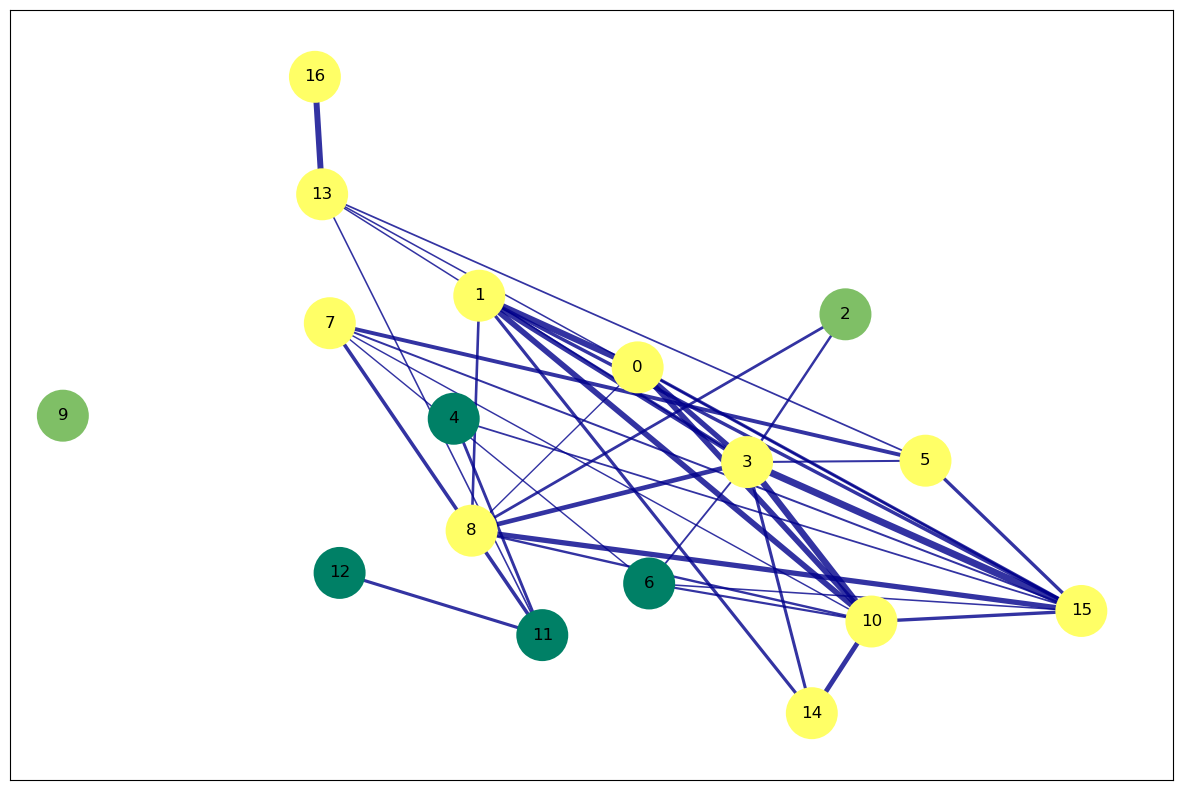

In [29]:
G_bray, G_bray_complete=plot_network(Bray, 0.6, same_position_data, df_info)

In [37]:
# Bray Curtis adjacency matrix generation
adj_matrix_Bray_audio = np.zeros((len(G_bray_complete), len(G_bray_complete)))

enlaces3 = G_bray.edges

for enlace in enlaces3:
    fila, columna = enlace
    adj_matrix_Bray_audio[fila, columna] = 1
    adj_matrix_Bray_audio[columna, fila] = 1

print(adj_matrix_Bray_audio)

[[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [39]:
# Spearman correlation coefficient
coef_spearman, p_value = spearmanr(adj_matrix_Bray_audio.flatten(), adj_matrix_Glasso_sonotipos.flatten())

print("Spearman correlation coefficient:", np.round(coef_spearman, decimals=2))
print("Valor p:", p_value)

Spearman correlation: 0.55
Valor p: 4.389808560906732e-24


# Spectral indices taken from Satellite imagery 

Load spectral indices dataframe for all buffers (50m, 100m, 200m)

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s
[GraphicalLassoCV] Done refinement  3 out of 4:   0s
[GraphicalLassoCV] Done refinement  4 out of 4:   0s
Buffer 50m
0.2428108998110719


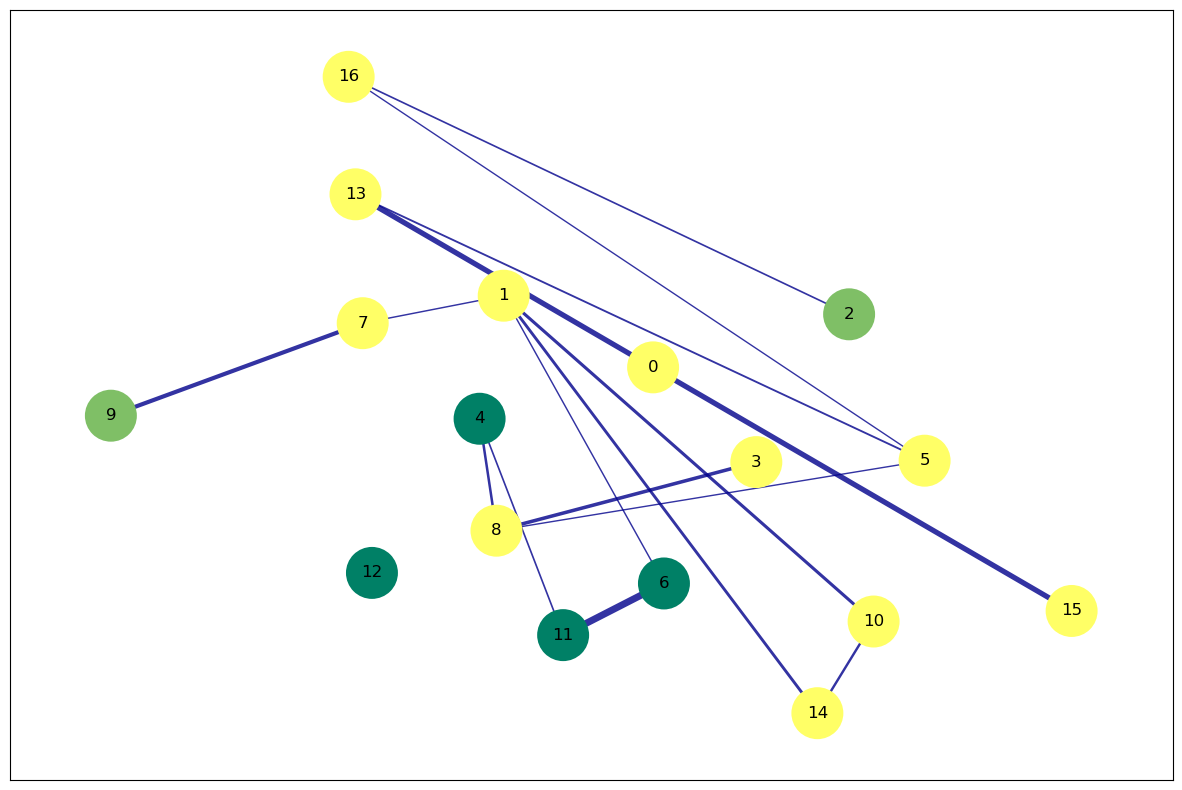

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s
[GraphicalLassoCV] Done refinement  3 out of 4:   0s
[GraphicalLassoCV] Done refinement  4 out of 4:   0s
Buffer 100m
0.34498392247356763


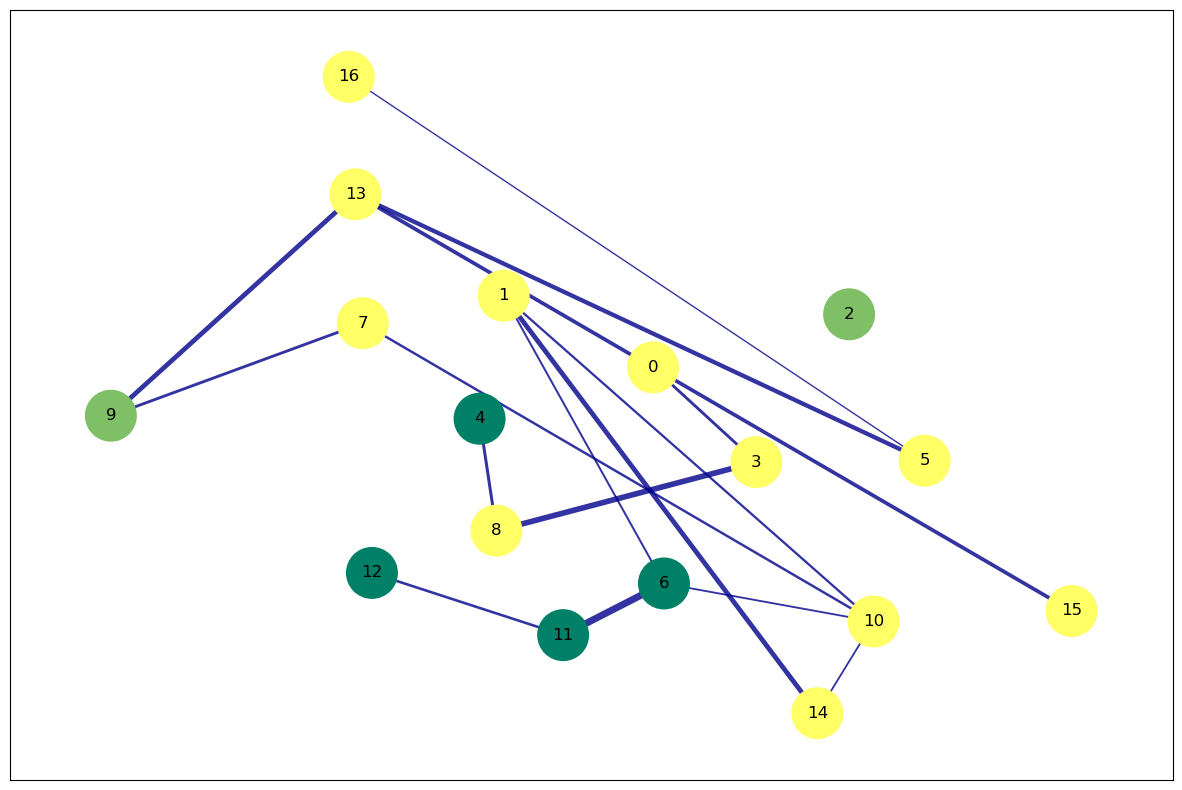

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s
[GraphicalLassoCV] Done refinement  3 out of 4:   0s
[GraphicalLassoCV] Done refinement  4 out of 4:   0s
Buffer 200m
0.34472637886660484


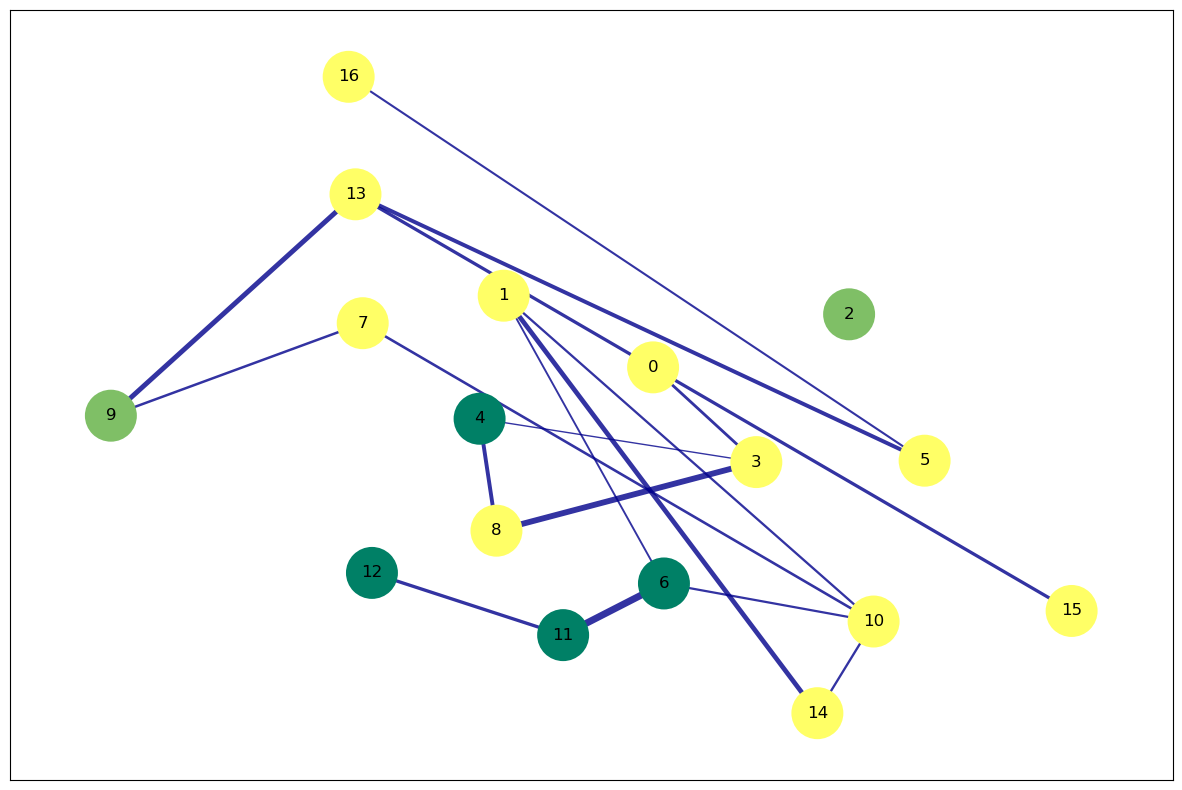

In [57]:
scaler = MinMaxScaler()
file_path = '/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Indices Satelitales/Estadisticas indices/datos organizados/median.xlsx'

# Lista de nombres de las hojas de cálculo
sheets = ['50m', '100m', '200m']

# Lista para almacenar las matrices de adyacencia
adjacency_matrices_median = []

for sheet in sheets:
    # Cargar los datos
    df = pd.read_excel(file_path, sheet_name=sheet)

    # Separar y normalizar los datos
    df2 = df.iloc[:,4:]
    df3 = df.iloc[:,0:4]
    df_norm = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

    # Procesar los datos
    datos = np.array(df_norm)
    datos2 = np.transpose(datos)
    datos2 /= datos2.std(axis=0)
    edge_model = GraphicalLassoCV(cv=5, max_iter=100, verbose=True, assume_centered=True)
    edge_model.fit(datos2)
    
    print('Buffer',sheet)
    print(edge_model.alpha_)
    
    p_satellite = np.around(edge_model.precision_, decimals=3)
    p_satellite = pd.DataFrame(p_satellite)
    A= np.around(edge_model.covariance_, decimals=3) #covarianza
    A=pd.DataFrame(A)

    G_satellite, G_satellite_complete=plot_network(p_satellite, 0.3, same_position_data, df_info)

    adj_matrix_1 = np.zeros((len(G_satellite_complete), len(G_satellite_complete)))

    for u, v in G_satellite.edges():
        adj_matrix_1[u, v] = 1
        adj_matrix_1[v, u] = 1

    adjacency_matrices_median.append(adj_matrix_1)



In [59]:
matriz_adj_median100m=pd.DataFrame(adjacency_matrices_median[1])
matriz_adj_median100m

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [65]:
# Spearman correlation coefficient
coef_spearman, p_value = spearmanr(adjacency_matrices_median[1].flatten(), adj_matrix_Glasso_sonotipos.flatten())

# Mostrar el coeficiente de correlación de Spearman median 100m
print("Spearman correlation coefficient:", np.round(coef_spearman, decimals=2))
print("p-value:", p_value)

Spearman correlation coefficient: 0.11
p-value: 0.06650257030289697
